In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T

In [2]:
DATA_PATH = '../../Datos'

In [3]:
NUM_TRAIN = 20000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 1

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

100%|██████████| 170498071/170498071 [00:14<00:00, 11407391.01it/s]


Extracting ../../Datos/cifar-10-python.tar.gz to ../../Datos
Files already downloaded and verified
Files already downloaded and verified


In [4]:
image = test_loader.dataset[2][0]
image = (image - image.min()) / (image.max() - image.min()) # preguntar
image_label = test_loader.dataset[2][1]

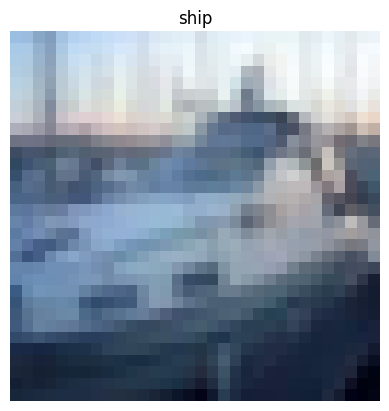

In [5]:
classes = test_loader.dataset.classes

plt.imshow(np.transpose(image,(1,2,0)))
plt.title(classes[image_label])
plt.axis('off')
plt.show()

# Caracterizacion con modelo preentrenado

In [6]:
import timm

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [11]:
model_feature = timm.create_model('resnet10t', pretrained = True)
model_features = model_feature.to(device=device)

In [12]:
def extra_f(loader):
  feature_output = []
  label_output = []
  model_feature.eval()

  for x, y in loader: 
    x = x.to(device=device, dtype = torch.float32)
    y = y.to(device=device, dtype = torch.long)

    features = model_feature.forward_features(x)
    feature_output.append(features.detach())
    label_output.append(y)

  feature_output = torch.squeeze(torch.cat(feature_output, 0))
  label_output = torch.cat(label_output,0)

  if loader == train_loader:
    m = "train"
  elif loader == val_loader:
    m = "val"
  else:
    m = "test"
  
  print(f"Features {m} {len(feature_output)}\nLabels {m} {len(label_output)}")
  
  return feature_output,label_output

# Grafo entrenamiento

In [13]:
feature_train, label_train = extra_f(train_loader)

Features train 20000
Labels train 20000


In [14]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

#Se crea los fetures de los nodos

x = feature_train

#Labels nodes

y = label_train

#Datos de entrenamiento y test

train_mask = [True for _ in range(len(y))]
train_mask = torch.tensor(train_mask)

#Se crea las conexines de los nodos

edge_index = knn_graph(x, k=10, batch=y, loop=False)


#Creacion del grafo 

data_train = Data(x=x, edge_index= edge_index, y = y , train_mask = train_mask)
data_train = data_train.to(device)

# Grafo de test

In [15]:
feature_test, label_test = extra_f(test_loader)

Features test 5000
Labels test 5000


In [16]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

#Se crea los fetures de los nodos

x1 = feature_test

#Labels nodes

y1 = label_test

#Datos de entrenamiento y test

test_mask = [True for _ in range(len(y1))]
test_mask = torch.tensor(test_mask)

#Se crea las conexines de los nodos

edge_index1 = knn_graph(x1, k=10, batch=y1, loop=False)


#Creacion del grafo 

data_test = Data(x=x1, edge_index= edge_index1, y = y1 , test_mask = test_mask)
data_test = data_test.to(device)

In [17]:
data_test

Data(x=[5000, 512], edge_index=[2, 49942], y=[5000], test_mask=[5000])

# Grafo de val

In [18]:
feature_val, label_val = extra_f(val_loader)

Features val 5000
Labels val 5000


In [19]:
#Se crea los fetures de los nodos

x2 = feature_val

#Labels nodes

y2 = label_val

#Datos de entrenamiento y test

val_mask = [True for _ in range(len(y2))]
val_mask = torch.tensor(val_mask)

#Se crea las conexines de los nodos

edge_index2 = knn_graph(x2, k=10, batch=y2, loop=False)


#Creacion del grafo 

data_val = Data(x=x2, edge_index= edge_index2, y = y2 , val_mask = val_mask)
data_val = data_val.to(device)

In [20]:
data_val

Data(x=[5000, 512], edge_index=[2, 50000], y=[5000], val_mask=[5000])

#TRAIN TEST

In [21]:
def accuracy(pred_y, y):
    
    return ((pred_y == y).sum() / len(y)).item()

def val(model, data_val):
  model.eval()
  out = model(data_val.x, data_val.edge_index)
  acc = accuracy(torch.argmax(out, dim = 1)[data_val.val_mask], data_val.y[data_val.val_mask])
  return acc

def test(model, data_test):
    model.eval()
    out = model(data_test.x, data_test.edge_index)
    acc = accuracy(torch.argmax(out, dim = 1)[data_test.test_mask], data_test.y[data_test.test_mask])
    return acc

def train(model, data_train, data_val, epochs):
    
    f_loss = nn.CrossEntropyLoss()
    optimizer = model.optimizer

    model.train()
    for epoch in range(epochs + 1):
        
        optimizer.zero_grad()
        out = model(data_train.x, data_train.edge_index)
        loss = f_loss(out[data_train.train_mask], data_train.y[data_train.train_mask])
        acc = accuracy(torch.argmax(out, dim = 1)[data_train.train_mask], data_train.y[data_train.train_mask])
        loss.backward()
        optimizer.step()

        
        val_acc = val(model, data_val)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% |' f'Val Acc: {val_acc*100:.2f}%')
          
    return model

# Modelos

In [22]:
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

## GAT

In [23]:
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=10):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.1, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.3, training=self.training)
    h = self.gat2(h, edge_index)
  
    return h

In [24]:
# Create GAT
gat = GAT(512, 20, len(classes)).to(device)

# Train
train(gat, data_train, data_val, epochs = 90)

acc = test(gat, data_test)

print(f'=============================================================\nAccuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.688 | Train Acc:   7.93% |Val Acc: 22.22%
Epoch  10 | Train Loss: 1.468 | Train Acc:  50.08% |Val Acc: 46.56%
Epoch  20 | Train Loss: 1.269 | Train Acc:  55.85% |Val Acc: 52.26%
Epoch  30 | Train Loss: 1.135 | Train Acc:  59.99% |Val Acc: 56.08%
Epoch  40 | Train Loss: 0.998 | Train Acc:  64.66% |Val Acc: 57.98%
Epoch  50 | Train Loss: 0.843 | Train Acc:  70.36% |Val Acc: 59.46%
Epoch  60 | Train Loss: 0.740 | Train Acc:  73.68% |Val Acc: 59.60%
Epoch  70 | Train Loss: 0.576 | Train Acc:  80.22% |Val Acc: 59.18%
Epoch  80 | Train Loss: 0.476 | Train Acc:  84.06% |Val Acc: 58.14%
Epoch  90 | Train Loss: 0.356 | Train Acc:  88.62% |Val Acc: 57.68%
Accuracy: 56.28%



## GCN

In [25]:
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.1, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.3, training=self.training)
    h = self.gcn2(h, edge_index)
    
    return h

In [26]:
# Create GAT
gcn = GCN(512, 20, len(classes)).to(device)

# Train
train(gcn, data_train, data_val, epochs = 90)

acc = test(gcn, data_test)

print(f'=============================================================\nAccuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.610 | Train Acc:  10.75% |Val Acc: 23.06%
Epoch  10 | Train Loss: 1.516 | Train Acc:  48.03% |Val Acc: 46.48%
Epoch  20 | Train Loss: 1.361 | Train Acc:  52.64% |Val Acc: 49.50%
Epoch  30 | Train Loss: 1.299 | Train Acc:  54.39% |Val Acc: 51.24%
Epoch  40 | Train Loss: 1.259 | Train Acc:  55.90% |Val Acc: 52.18%
Epoch  50 | Train Loss: 1.231 | Train Acc:  56.72% |Val Acc: 53.58%
Epoch  60 | Train Loss: 1.210 | Train Acc:  57.44% |Val Acc: 53.16%
Epoch  70 | Train Loss: 1.194 | Train Acc:  58.02% |Val Acc: 53.16%
Epoch  80 | Train Loss: 1.180 | Train Acc:  58.56% |Val Acc: 53.16%
Epoch  90 | Train Loss: 1.173 | Train Acc:  58.78% |Val Acc: 52.76%
Accuracy: 50.32%



## SAGE

In [27]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.1)
        h = self.conv1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.3)
        h = self.conv2(h, edge_index)
       
        return h

In [28]:
# Create GAT
g_sage = GraphSAGE(512, 20, len(classes)).to(device)

# Train
train(g_sage, data_train, data_val, epochs = 90)

acc = test(g_sage, data_test)

print(f'=============================================================\nAccuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.387 | Train Acc:  12.30% |Val Acc: 22.44%
Epoch  10 | Train Loss: 1.353 | Train Acc:  53.54% |Val Acc: 52.78%
Epoch  20 | Train Loss: 1.196 | Train Acc:  58.50% |Val Acc: 57.08%
Epoch  30 | Train Loss: 1.101 | Train Acc:  61.41% |Val Acc: 58.70%
Epoch  40 | Train Loss: 1.039 | Train Acc:  63.73% |Val Acc: 59.52%
Epoch  50 | Train Loss: 1.003 | Train Acc:  64.63% |Val Acc: 60.14%
Epoch  60 | Train Loss: 0.974 | Train Acc:  65.78% |Val Acc: 60.46%
Epoch  70 | Train Loss: 0.951 | Train Acc:  66.10% |Val Acc: 60.72%
Epoch  80 | Train Loss: 0.935 | Train Acc:  66.81% |Val Acc: 60.70%
Epoch  90 | Train Loss: 0.923 | Train Acc:  67.37% |Val Acc: 61.60%
Accuracy: 60.42%

